Our code is referring to the following pages:

https://blog.keras.io/building-autoencoders-in-keras.html


https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import random
import pickle
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import keras
from keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks

Import Minist dataset

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Create the function build_X_Y() to build the training set and test set in the case where the training set contains some outliers. 

In [ ]:
def build_X_Y(data, labels, validLabel, anomalyLabel, contam):
# Find the ValidLabel  
  validIdxs = np.where(np.isin(labels,[validLabel]))[0]
  X_norm = data[validIdxs]
  Y_norm = labels[validIdxs]

# We remain only a proportion of anomalies (defined as contam)
  len_attack = len(X_norm)*contam 

# Find the Anomalies 
  attackIdxs = np.where(labels == anomalyLabel)[0]
  X_attack = data[attackIdxs]
  Y_attack = labels[attackIdxs]
  X_attack = X_attack[:int(len_attack)]
  Y_attack = Y_attack[:int(len_attack)]

  X_data = np.concatenate([X_norm, X_attack])
  Y_data = np.concatenate([Y_norm, Y_attack])

  return X_data, Y_data

Parameters' explanations of build_X_Y()

*   ***data***: the pixel of the images in x_train or x_test
*   ***labels***: the label of each image, as known as y_train or y_test of the original data. 
*   ***validLabel***: labels of the normal image that we chose. You can enter a single value or multiple values. If you want to enter multiple values, you have to put "," to seperate them. (e.g. 1,2,3)
*   ***anomalyLabel***: label of the outlier that we chose
*   ***contam***: ratio of anomlies to normal images





Output of build_X_Y()


*   ***X_data***: the set of the images contamed with some outliers
*   ***Y_data***: label of the X_data





Create the function build_X_train_nocontam() to build the training set without outliers 

In [ ]:
def build_X_train_nocontam(data, labels, validLabel):
   
   validIdxs = np.where(np.isin(labels,[validLabel]))[0]
   X_norm = data[validIdxs]
   Y_norm = labels[validIdxs]
   
   return X_norm, Y_norm 

Parameters' explanations of build_X_train_nocontam()

*   ***data***: the pixel of the images in x_train
*   ***labels***: the label of each image, as known as y_train of the original data.


*   ***validLabel***: labels of the normal images that we chose. You can enter a single value or multiple values. If you want to enter multiple values, you have to put "," to seperate them. (e.g. 1,2,3)


## ValidLabel = 1 v.s. AnomalLabel = 8

### Construction of training set and test set

In [ ]:
validLabel=1
anomalyLabel=8
contam=0.05

Build training set

Case1: A small proportion of outliers in the training set

In [ ]:
# Training set with a little outliers
(X_train_contam, Y_train) = build_X_Y(x_train,y_train,validLabel,anomalyLabel,contam=0.05)

In [ ]:
print(X_train_contam.shape)

(7079, 28, 28)


Case 2: No outliers in the training set

In [ ]:
X_train_norm, Y_train_norm = build_X_train_nocontam(x_train,y_train,validLabel)
print(X_train_norm.shape)

(6742, 28, 28)


Build test set

In [ ]:
# Test set
(X_test, Y_test) = build_X_Y(x_test,y_test,validLabel,anomalyLabel,contam=0.05)

In [ ]:
print(X_test.shape)
print(Y_test.shape)

(1191, 28, 28)
(1191,)


*Noted that contam=0.05 in the two functions, meaning that anormalies account for 5% of the normal data in both training set and test set. 

Nomorlize the pixel and flatten the images

In [ ]:
def normal_img(train_X,train_X_normal,test_X):
  X_train = train_X.astype('float32') / 255.
  X_normal = train_X_normal.astype('float32') / 255.
  X_test = test_X.astype('float32') / 255.
  
  X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
  X_normal = X_normal.reshape(len(X_normal), np.prod(X_normal.shape[1:]))
  X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
  return X_train, X_normal, X_test

In [ ]:
(X_train_contam, X_train_norm, X_test) = normal_img(X_train_contam, X_train_norm, X_test)

print(X_train_contam.shape)
print(X_train_norm.shape)
print(X_test.shape)

(7079, 784)
(6742, 784)
(1191, 784)


### Simple autoencoder

In [ ]:
def simple_autoencoder(X_train, X_test, epochs):
 # This is the size of our encoded representations
 encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

 # This is our input image
 input_img = keras.Input(shape=(784,))
 # "encoded" is the encoded representation of the input
 encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
 # "decoded" is the lossy reconstruction of the input
 decoded = layers.Dense(784, activation='sigmoid')(encoded)

 # This model maps an input to its reconstruction
 autoencoder = keras.Model(input_img, decoded)


 # This model maps an input to its encoded representation
 encoder = keras.Model(input_img, encoded)

 # This is our encoded (32-dimensional) input
 encoded_input = keras.Input(shape=(encoding_dim,))
 # Retrieve the last layer of the autoencoder model
 decoder_layer = autoencoder.layers[-1]
 # Create the decoder model
 decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

 # We'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:
 autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

 # result of training only the normal data
 result_simple_1 = autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

 plt.plot(result_simple_1.history['loss'])
 plt.title('model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper right');
 plt.show()

 # Encode and decode some digits
 # Note that we take them from the *test* set
 encoded_imgs = encoder.predict(X_test)
 decoded_imgs = decoder.predict(encoded_imgs)
 return decoded_imgs 

### We first train the data without outliers (X_train_norm)

Train on 6742 samples, validate on 1191 samples
Epoch 1/70
6400/6742 [===========================>..] - ETA: 0s - loss: 0.5851

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6742/6742 [==============================] - 2s 228us/sample - loss: 0.5742 - val_loss: 0.3393
Epoch 2/70
6742/6742 [==============================] - 0s 50us/sample - loss: 0.2062 - val_loss: 0.1593
Epoch 3/70
6742/6742 [==============================] - 0s 49us/sample - loss: 0.1285 - val_loss: 0.1330
Epoch 4/70
6742/6742 [==============================] - 0s 46us/sample - loss: 0.1086 - val_loss: 0.1158
Epoch 5/70
6742/6742 [==============================] - 0s 51us/sample - loss: 0.0971 - val_loss: 0.1067
Epoch 6/70
6742/6742 [==============================] - 0s 47us/sample - loss: 0.0909 - val_loss: 0.1006
Epoch 7/70
6742/6742 [==============================] - 0s 48us/sample - loss: 0.0864 - val_loss: 0.0958
Epoch 8/70
6742/6742 [==============================] - 0s 49us/sample - loss: 0.0831 - val_loss: 0.0928
Epoch 9/70
6742/6742 [==============================] - 0s 49us/sample - loss: 0.0807 - val_loss: 0.0904
Epoch 10/70
6742/6742 [==============================] - 0s 46us/

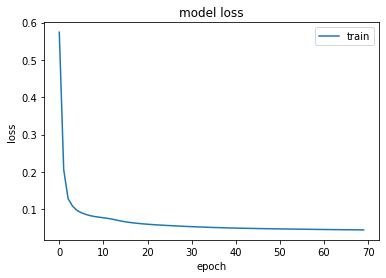

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
decoded_imgs = simple_autoencoder(X_train_norm,X_test,70)

In [ ]:
# Measure the error between the reconstruction and the original image
def cal_mse(reconstruction,original):
  mse = np.mean((reconstruction - original) ** 2,axis=1)
  return mse

In [ ]:
mse_s=cal_mse(decoded_imgs,X_test)

#Define the anomaly threshold by 1/(1+contam), 1/(1+contam) is the proportion of the normal data in the whole test set
thresh = np.quantile(mse_s, 1/(1+contam))
idxs = np.where(np.array(mse_s) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.02793895825743655
[INFO] 57 outliers found


In [ ]:
# Predicted Y
Y_pred = np.array([1]*len(Y_test))
Y_pred[idxs] = 8 
Y_pred

array([1, 1, 1, ..., 8, 8, 8])

In [ ]:
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

[[1131    4]
 [   3   53]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1135
           8       0.93      0.95      0.94        56

    accuracy                           0.99      1191
   macro avg       0.96      0.97      0.97      1191
weighted avg       0.99      0.99      0.99      1191



Recall_8 = 0.95 measures the proportion of success detection. Among 56 outliers, we can find about 96% outliers by our simple autoencoder model quite good!

In [ ]:
# See the false predicted images
def false_image(predict_Y,real_Y,real_X):
  idxs_false = np.where(real_Y != predict_Y)[0]

  n = len(idxs_false)  # How many digits we will display
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # Display original,row_num represent that how many rows of images you want when displaying the images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(real_X[idxs_false[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idxs_false[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

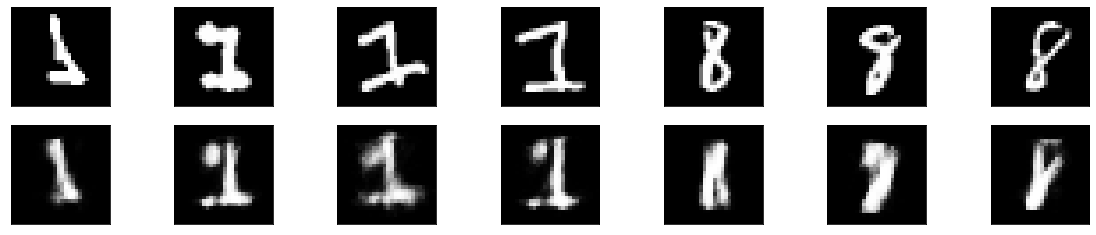

In [ ]:
 plot_s = false_image(Y_pred,Y_test,X_test)

### We then train the data with outliers (X_train_contam)

Train on 7079 samples, validate on 1191 samples
Epoch 1/50
6912/7079 [============================>.] - ETA: 0s - loss: 0.5731

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7079/7079 [==============================] - 1s 207us/sample - loss: 0.5677 - val_loss: 0.3350
Epoch 2/50
7079/7079 [==============================] - 0s 44us/sample - loss: 0.2144 - val_loss: 0.1518
Epoch 3/50
7079/7079 [==============================] - 0s 46us/sample - loss: 0.1365 - val_loss: 0.1191
Epoch 4/50
7079/7079 [==============================] - 0s 48us/sample - loss: 0.1115 - val_loss: 0.1016
Epoch 5/50
7079/7079 [==============================] - 0s 46us/sample - loss: 0.0987 - val_loss: 0.0931
Epoch 6/50
7079/7079 [==============================] - 0s 48us/sample - loss: 0.0919 - val_loss: 0.0881
Epoch 7/50
7079/7079 [==============================] - 0s 49us/sample - loss: 0.0877 - val_loss: 0.0848
Epoch 8/50
7079/7079 [==============================] - 0s 47us/sample - loss: 0.0847 - val_loss: 0.0821
Epoch 9/50
7079/7079 [==============================] - 0s 48us/sample - loss: 0.0823 - val_loss: 0.0800
Epoch 10/50
7079/7079 [==============================] - 0s 48us/

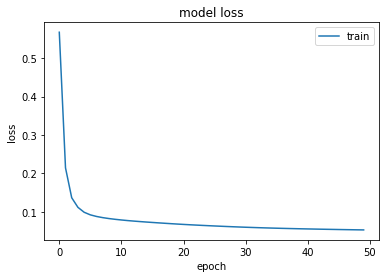

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
decoded_imgs_o = simple_autoencoder(X_train_contam,X_test,50)

In [ ]:
mse_s_o=cal_mse(decoded_imgs_o,X_test)

In [ ]:
# Define the anomaly threshold by 1/(1+contam)
thresh_o = np.quantile(mse_s_o, 1/(1+contam))
idxs_o = np.where(np.array(mse_s_o) >= thresh_o)[0]
print("[INFO] mse threshold: {}".format(thresh_o))
print("[INFO] {} outliers found".format(len(idxs_o)))

[INFO] mse threshold: 0.024245460828145333
[INFO] 57 outliers found


In [ ]:
# Predicted Y
Y_pred_o = np.array([1]*len(Y_test))
Y_pred_o[idxs_o] = 8
Y_pred_o

array([1, 1, 1, ..., 8, 8, 1])

In [ ]:
print(confusion_matrix(Y_test, Y_pred_o))
print(classification_report(Y_test, Y_pred_o))

[[1124   11]
 [  10   46]]
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      1135
           8       0.81      0.82      0.81        56

    accuracy                           0.98      1191
   macro avg       0.90      0.91      0.90      1191
weighted avg       0.98      0.98      0.98      1191



recall_8=82%. Among 56 outliers, we can find about 82% outliers by our simple simple autoencoder model in the contam case.



###Deep fully-connected autoencoder

In [ ]:
def deep_autoencoder(X_train, X_test, epochs):
  #Instead of using only single layer for encoder and decoder model, we can use several layers 
  encoding_dim = 32
  input_img_d = keras.Input(shape=(784,))
  encoded = layers.Dense(128, activation='relu')(input_img_d)
  encoded = layers.Dense(64, activation='relu')(encoded)
  encoded = layers.Dense(32, activation='relu')(encoded)

  decoded = layers.Dense(64, activation='relu')(encoded)
  decoded = layers.Dense(128, activation='relu')(decoded)
  decoded = layers.Dense(784, activation='sigmoid')(decoded)

  autoencoder_deep = keras.Model(input_img_d, decoded)

  autoencoder_deep.compile(optimizer='adam', loss='binary_crossentropy')

  result_d=autoencoder_deep.fit(X_train, X_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
  
  # plot loss function
  plt.plot(result_d.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right');
  plt.show()

  X_pred_d = autoencoder_deep.predict(X_test)

  return X_pred_d 

Train on 6742 samples, validate on 1191 samples
Epoch 1/50
6400/6742 [===========================>..] - ETA: 0s - loss: 0.4540

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6742/6742 [==============================] - 2s 257us/sample - loss: 0.4392 - val_loss: 0.1925
Epoch 2/50
6742/6742 [==============================] - 0s 66us/sample - loss: 0.1325 - val_loss: 0.1290
Epoch 3/50
6742/6742 [==============================] - 0s 68us/sample - loss: 0.1048 - val_loss: 0.1021
Epoch 4/50
6742/6742 [==============================] - 0s 67us/sample - loss: 0.0872 - val_loss: 0.0913
Epoch 5/50
6742/6742 [==============================] - 0s 67us/sample - loss: 0.0794 - val_loss: 0.0864
Epoch 6/50
6742/6742 [==============================] - 0s 70us/sample - loss: 0.0756 - val_loss: 0.0828
Epoch 7/50
6742/6742 [==============================] - 0s 69us/sample - loss: 0.0722 - val_loss: 0.0783
Epoch 8/50
6742/6742 [==============================] - 0s 67us/sample - loss: 0.0674 - val_loss: 0.0740
Epoch 9/50
6742/6742 [==============================] - 0s 67us/sample - loss: 0.0645 - val_loss: 0.0721
Epoch 10/50
6742/6742 [==============================] - 0s 70us/

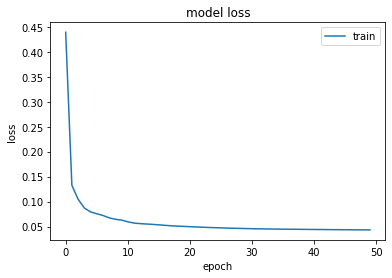

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
X_pred_d = deep_autoencoder(X_train_norm,X_test,50)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_d = cal_mse(X_pred_d, X_test)

In [ ]:
#Define the anomaly threshold by 1/(1+contam)
thresh_d = np.quantile(mse_d, 1/(1+contam))
idxs_d = np.where(np.array(mse_d) >= thresh_d)[0]
print("[INFO] mse threshold: {}".format(thresh_d))
print("[INFO] {} outliers found".format(len(idxs_d)))

[INFO] mse threshold: 0.033230805148680854
[INFO] 57 outliers found


In [ ]:
# Predicted Y
Y_pred_d = np.array([1]*len(Y_test))
Y_pred_d[idxs_d] = 8
Y_pred_d

array([1, 1, 1, ..., 8, 8, 8])

In [ ]:
print(confusion_matrix(Y_test, Y_pred_d))
print(classification_report(Y_test, Y_pred_d))

[[1132    3]
 [   2   54]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1135
           8       0.95      0.96      0.96        56

    accuracy                           1.00      1191
   macro avg       0.97      0.98      0.98      1191
weighted avg       1.00      1.00      1.00      1191



Recall_8 = 0.96 measures the proportion of success detection. Among 56 outliers, we can find about 96% outliers by Deep fully-connected autoencoder model, same with the simple autoencoder

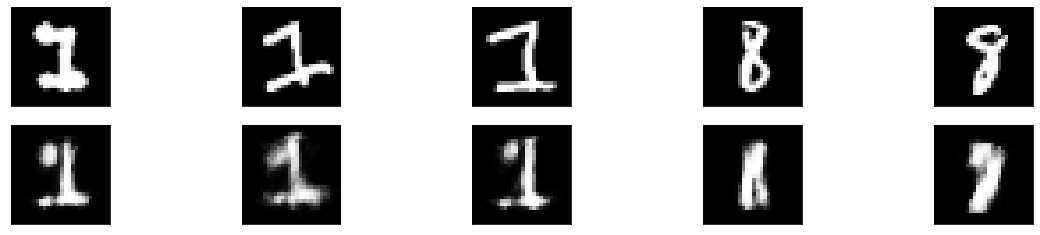

In [ ]:
# See the false predicted images
plot_d=false_image(Y_pred_d,Y_test,X_test)

### Variational autoencoder

In [ ]:
# The reparameterization
def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var) * epsilon

In [ ]:
original_dim = X_train_norm.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_79 (Dense)               (None, 392)          307720      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 261)          102573      ['dense_79[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 261)          102573      ['dense_79[0][0]']               
                                                                                            

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 261)]             0         
                                                                 
 dense_80 (Dense)            (None, 392)               102704    
                                                                 
 dense_81 (Dense)            (None, 784)               308112    
                                                                 
Total params: 410,816
Trainable params: 410,816
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 261)               512866    
                                                                 
 decoder (Functional)        (None, 784)               410816    
                                                                 
Total params: 923,682
Trainable params: 923,682
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Finally, we train the model:
results = vae_model.fit(X_train_norm, X_train_norm,
                        shuffle=True,
                        epochs=32,
                        batch_size=100)

Train on 6742 samples
Epoch 1/32
6742/6742 [==============================] - 3s 404us/sample - loss: 11742.4182
Epoch 2/32
6742/6742 [==============================] - 2s 250us/sample - loss: 2487.4267
Epoch 3/32
6742/6742 [==============================] - 2s 251us/sample - loss: 1425.4134
Epoch 4/32
6742/6742 [==============================] - 2s 247us/sample - loss: 1114.8806
Epoch 5/32
6742/6742 [==============================] - 2s 248us/sample - loss: 929.6518
Epoch 6/32
6742/6742 [==============================] - 2s 251us/sample - loss: 748.9645
Epoch 7/32
6742/6742 [==============================] - 2s 253us/sample - loss: 632.7491
Epoch 8/32
6742/6742 [==============================] - 2s 256us/sample - loss: 562.1408
Epoch 9/32
6742/6742 [==============================] - 2s 256us/sample - loss: 510.7184
Epoch 10/32
6742/6742 [==============================] - 2s 262us/sample - loss: 473.9628
Epoch 11/32
6742/6742 [==============================] - 2s 257us/sample - loss: 4

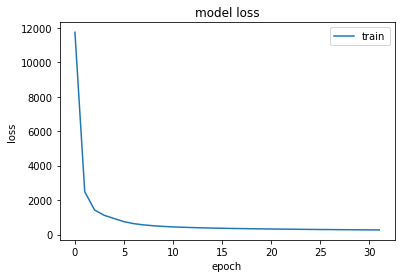

In [ ]:
#Plot the trend of loss
plt.plot(results.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
#Use the model trained to do prediction in test set
X_pred_v = vae_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Measure the error between the reconstruction and the original image
mse_v = cal_mse(X_pred_v, X_test) 

In [ ]:
#Define the anomaly threshold by 1/(1+contam)
thresh_v = np.quantile(mse_v, 1/(1+contam))
idxs_v = np.where(np.array(mse_v) >= thresh_v)[0]
print("[INFO] mse threshold: {}".format(thresh_v))
print("[INFO] {} outliers found".format(len(idxs_v)))

[INFO] mse threshold: 0.02244914819796874
[INFO] 57 outliers found


In [ ]:
# Predicted Y
Y_pred_v = np.array([1]*len(Y_test))
Y_pred_v[idxs_v] = 8
Y_pred_v

array([1, 1, 1, ..., 8, 8, 8])

In [ ]:
print(confusion_matrix(Y_test, Y_pred_v))
print(classification_report(Y_test, Y_pred_v))

[[1132    3]
 [   2   54]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1135
           8       0.95      0.96      0.96        56

    accuracy                           1.00      1191
   macro avg       0.97      0.98      0.98      1191
weighted avg       1.00      1.00      1.00      1191



Recall_8 = 0.93 measures the proportion of success detection. Among 56 outliers, we can find about 93% outliers by variational autoencoder model, a little worse than the previous two methods

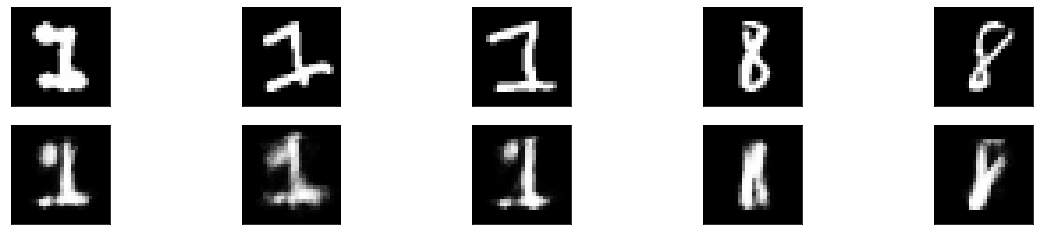

In [ ]:
# See the false predicted images
plot_v=false_image(Y_pred_v,Y_test,X_test)

## NormalLabel=0,1,2,3,4,5,6,7,9 v.s. AnomalLabel = 8

Instead of putting only two digits (1 as normal, 8 as anomaly) in our dataset, now we take all the digits and set 8 as an anomaly, then try to detect it from digit 0 to 9 with autoencoder model.

### Data Preparation (Same as above)

In [ ]:
validLabel2=0,1,2,3,4,5,6,7,9
anomalyLabel2=8
contam=0.05

In [ ]:
X_train_2, Y_train_2 = build_X_train_nocontam(x_train,y_train,validLabel2)
print(X_train_2.shape)
(X_test_2, Y_test_2) = build_X_Y(x_test,y_test,validLabel2,anomalyLabel2,contam=0.05)
print(X_test_2.shape)
print(Y_test_2.shape)

(54149, 28, 28)
(9477, 28, 28)
(9477,)


In [ ]:
def normal_img_2(train_X,test_X):
  X_train = train_X.astype('float32') / 255.
  X_test = test_X.astype('float32') / 255.
  
  X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
  X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
  return X_train,X_test

In [ ]:
(X_train_2, X_test_2) = normal_img_2(X_train_2, X_test_2)
print(X_train_2.shape)
print(X_test_2.shape)

(54149, 784)
(9477, 784)


###Simple autoencoder

Train on 54149 samples, validate on 9477 samples
Epoch 1/80
53504/54149 [============================>.] - ETA: 0s - loss: 0.2853

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54149/54149 [==============================] - 4s 69us/sample - loss: 0.2842 - val_loss: 0.1943
Epoch 2/80
54149/54149 [==============================] - 3s 47us/sample - loss: 0.1731 - val_loss: 0.1579
Epoch 3/80
54149/54149 [==============================] - 3s 47us/sample - loss: 0.1456 - val_loss: 0.1377
Epoch 4/80
54149/54149 [==============================] - 2s 46us/sample - loss: 0.1296 - val_loss: 0.1252
Epoch 5/80
54149/54149 [==============================] - 2s 45us/sample - loss: 0.1191 - val_loss: 0.1163
Epoch 6/80
54149/54149 [==============================] - 3s 46us/sample - loss: 0.1120 - val_loss: 0.1102
Epoch 7/80
54149/54149 [==============================] - 2s 46us/sample - loss: 0.1067 - val_loss: 0.1055
Epoch 8/80
54149/54149 [==============================] - 3s 46us/sample - loss: 0.1025 - val_loss: 0.1017
Epoch 9/80
54149/54149 [==============================] - 2s 46us/sample - loss: 0.0993 - val_loss: 0.0989
Epoch 10/80
54149/54149 [=======================

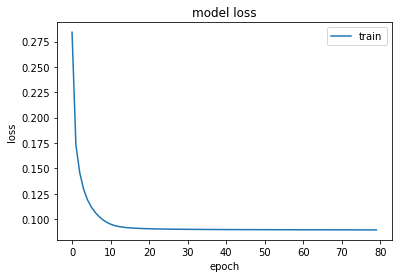

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
decoded_imgs_2 = simple_autoencoder(X_train_2,X_test_2,80)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_s_2 = cal_mse(decoded_imgs_2, X_test_2) 

In [ ]:
thresh_2 = np.quantile(mse_s_2, 1/(1+contam))
idxs_2 = np.where(np.array(mse_s_2) >= thresh_2)[0]
print("[INFO] mse threshold: {}".format(thresh_2))
print("[INFO] {} outliers found".format(len(idxs_2)))

[INFO] mse threshold: 0.02059442044368812
[INFO] 452 outliers found


In [ ]:
# Predicted Y
# We set all the normal digits as 1 to simplify the comparison
Y_pred_2 = np.array([1]*len(Y_test_2))
Y_pred_2[idxs_2] = 8
print(Y_pred_2)

Y_test_2_ = Y_test_2.copy()
Y_test_2_[Y_test_2_ != 8] = 1
print(Y_test_2_)

[1 1 1 ... 1 1 1]
[1 1 1 ... 8 8 8]


In [ ]:
print(confusion_matrix(Y_test_2_, Y_pred_2))
print(classification_report(Y_test_2_, Y_pred_2))

[[8738  288]
 [ 287  164]]
              precision    recall  f1-score   support

           1       0.97      0.97      0.97      9026
           8       0.36      0.36      0.36       451

    accuracy                           0.94      9477
   macro avg       0.67      0.67      0.67      9477
weighted avg       0.94      0.94      0.94      9477



###Deep fully-connected autoencoder

Train on 54149 samples, validate on 9477 samples
Epoch 1/50
53504/54149 [============================>.] - ETA: 0s - loss: 0.2496

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54149/54149 [==============================] - 5s 92us/sample - loss: 0.2486 - val_loss: 0.1694
Epoch 2/50
54149/54149 [==============================] - 4s 65us/sample - loss: 0.1522 - val_loss: 0.1401
Epoch 3/50
54149/54149 [==============================] - 4s 65us/sample - loss: 0.1315 - val_loss: 0.1270
Epoch 4/50
54149/54149 [==============================] - 4s 65us/sample - loss: 0.1214 - val_loss: 0.1195
Epoch 5/50
54149/54149 [==============================] - 4s 65us/sample - loss: 0.1152 - val_loss: 0.1143
Epoch 6/50
54149/54149 [==============================] - 3s 64us/sample - loss: 0.1105 - val_loss: 0.1098
Epoch 7/50
54149/54149 [==============================] - 3s 64us/sample - loss: 0.1067 - val_loss: 0.1065
Epoch 8/50
54149/54149 [==============================] - 3s 64us/sample - loss: 0.1039 - val_loss: 0.1046
Epoch 9/50
54149/54149 [==============================] - 4s 65us/sample - loss: 0.1017 - val_loss: 0.1021
Epoch 10/50
54149/54149 [=======================

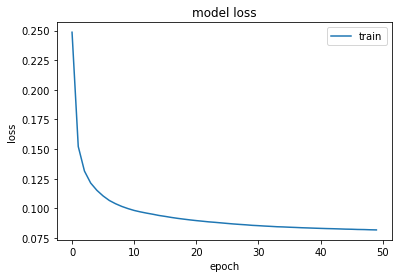

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
X_pred_d_2 = deep_autoencoder(X_train_2,X_test_2,50)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_d_2 = cal_mse(X_pred_d_2, X_test_2) 

In [ ]:
thresh_d_2 = np.quantile(mse_d_2, 1/(1+contam))
idxs_d_2 = np.where(np.array(mse_d_2) >= thresh_d_2)[0]
print("[INFO] mse threshold: {}".format(thresh_d_2))
print("[INFO] {} outliers found".format(len(idxs_d_2)))

[INFO] mse threshold: 0.01681552437089738
[INFO] 452 outliers found


In [ ]:
# Predicted Y
# We set all the normal digits as 1 to simplify the comparison
Y_pred_d_2 = np.array([1]*len(Y_test_2))
Y_pred_d_2[idxs_d_2] = 8
print(Y_pred_d_2)

Y_test_2_ = Y_test_2.copy()
Y_test_2_[Y_test_2_ != 8] = 1
print(Y_test_2_)


[1 1 1 ... 1 1 1]
[1 1 1 ... 8 8 8]


In [ ]:
print(confusion_matrix(Y_test_2_, Y_pred_d_2))

[[8726  300]
 [ 299  152]]


In [ ]:
print(classification_report(Y_test_2_, Y_pred_d_2))

              precision    recall  f1-score   support

           1       0.97      0.97      0.97      9026
           8       0.34      0.34      0.34       451

    accuracy                           0.94      9477
   macro avg       0.65      0.65      0.65      9477
weighted avg       0.94      0.94      0.94      9477



###Variational autoencoder

In [ ]:
#We use the variational autoencoder that we built before
results_v_2 = vae_model.fit(X_train_2, X_train_2,
                        shuffle=True,
                        epochs=32,
                        batch_size=256,
                        validation_data=(X_test_2, X_test_2))

Train on 54149 samples, validate on 9477 samples
Epoch 1/32
54016/54149 [============================>.] - ETA: 0s - loss: 5581.8201

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54149/54149 [==============================] - 11s 195us/sample - loss: 5573.1758 - val_loss: 3659.6810
Epoch 2/32
54149/54149 [==============================] - 10s 187us/sample - loss: 3086.2864 - val_loss: 2666.0221
Epoch 3/32
54149/54149 [==============================] - 10s 189us/sample - loss: 2415.3582 - val_loss: 2201.5467
Epoch 4/32
54149/54149 [==============================] - 10s 189us/sample - loss: 2073.6921 - val_loss: 1948.5889
Epoch 5/32
54149/54149 [==============================] - 10s 189us/sample - loss: 1865.6378 - val_loss: 1772.8024
Epoch 6/32
54149/54149 [==============================] - 10s 188us/sample - loss: 1717.7874 - val_loss: 1652.9611
Epoch 7/32
54149/54149 [==============================] - 10s 187us/sample - loss: 1606.5277 - val_loss: 1548.2914
Epoch 8/32
54149/54149 [==============================] - 10s 187us/sample - loss: 1515.6964 - val_loss: 1470.4845
Epoch 9/32
54149/54149 [==============================] - 10s 184us/sample - loss: 1445.396

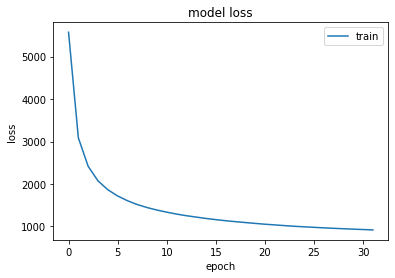

In [ ]:
#Plot the trend of loss
plt.plot(results_v_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
#Use the model trained to do prediction in test set
X_pred_v_2 = vae_model.predict(X_test_2)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_v_2 = cal_mse(X_pred_v_2, X_test_2) 

In [ ]:
#Define the anomaly threshold by 0.91 because anaomalies represent 9% of the whole dataset
thresh_v_2 = np.quantile(mse_v_2, 1/(1+contam))
idxs_v_2 = np.where(np.array(mse_v_2) >= thresh_v_2)[0]
print("[INFO] mse threshold: {}".format(thresh_v_2))
print("[INFO] {} outliers found".format(len(idxs_v_2)))

[INFO] mse threshold: 0.008005526892486072
[INFO] 452 outliers found


In [ ]:
# Predicted Y
# We set all the normal digits as 1 to simplify the comparison
Y_pred_v_2 = np.array([1]*len(Y_test_2))
Y_pred_v_2[idxs_v_2] = 8
Y_pred_v_2

Y_test_2_ = Y_test_2.copy()
Y_test_2_[Y_test_2_ != 8] = 1
print(Y_test_2_)

[1 1 1 ... 8 8 8]


In [ ]:
print(confusion_matrix(Y_test_2_, Y_pred_v_2))
print(classification_report(Y_test_2_, Y_pred_v_2))

[[8601  425]
 [ 424   27]]
              precision    recall  f1-score   support

           1       0.95      0.95      0.95      9026
           8       0.06      0.06      0.06       451

    accuracy                           0.91      9477
   macro avg       0.51      0.51      0.51      9477
weighted avg       0.91      0.91      0.91      9477



# Fashion Mnist

### Load the fashion minist dataset

In [ ]:
# Load Fashion-MNIST data
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
print('Fashion MNIST Dataset Shape:')
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_test:  '  + str(x_test.shape))
print('y_test:  '  + str(y_test.shape))

Fashion MNIST Dataset Shape:
x_train: (60000, 28, 28)
y_train: (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


Label	Description

**0**	T-shirt/top
**1**	Trouser
**2**	Pullover
**3**	Dress
**4**	Coat

**5**	Sandal
**6**	Shirt
**7**	Sneaker
**8**	Bag
**9**	Ankle boot

In [ ]:
validLabel3=1
anomalyLabel3=7
contam=0.05

In [ ]:
X_train_3,Y_train_3 = build_X_train_nocontam(x_train,y_train,validLabel3)
print(X_train_3.shape)
(X_test_3, Y_test_3) = build_X_Y(x_test,y_test,validLabel3,anomalyLabel3,contam=0.05)
print(X_test_3.shape)
print(Y_test_3.shape)

(6000, 28, 28)
(1050, 28, 28)
(1050,)


In [ ]:
# Normalize dataset and flatten the matrix to a vector
(X_train_3, X_test_3) = normal_img_2(X_train_3, X_test_3)
print(X_train_3.shape)
print(X_test_3.shape)

(6000, 784)
(1050, 784)


### Simple autoencoder

Train on 6000 samples, validate on 1050 samples
Epoch 1/50
5888/6000 [============================>.] - ETA: 0s - loss: 0.5823

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 285us/sample - loss: 0.5788 - val_loss: 0.3969
Epoch 2/50
6000/6000 [==============================] - 0s 48us/sample - loss: 0.3043 - val_loss: 0.2856
Epoch 3/50
6000/6000 [==============================] - 0s 45us/sample - loss: 0.2569 - val_loss: 0.2713
Epoch 4/50
6000/6000 [==============================] - 0s 50us/sample - loss: 0.2437 - val_loss: 0.2607
Epoch 5/50
6000/6000 [==============================] - 0s 48us/sample - loss: 0.2356 - val_loss: 0.2545
Epoch 6/50
6000/6000 [==============================] - 0s 47us/sample - loss: 0.2311 - val_loss: 0.2506
Epoch 7/50
6000/6000 [==============================] - 0s 50us/sample - loss: 0.2275 - val_loss: 0.2468
Epoch 8/50
6000/6000 [==============================] - 0s 47us/sample - loss: 0.2239 - val_loss: 0.2435
Epoch 9/50
6000/6000 [==============================] - 0s 48us/sample - loss: 0.2201 - val_loss: 0.2404
Epoch 10/50
6000/6000 [==============================] - 0s 48us/

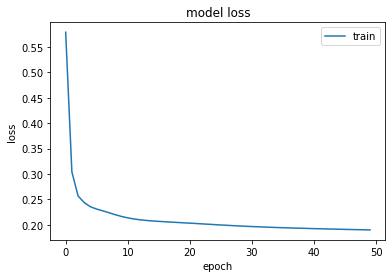

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
X_pred_s_3 = simple_autoencoder(X_train_3,X_test_3,50)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_s_3 = cal_mse(X_pred_s_3, X_test_3)

In [ ]:
thresh_3_s = np.quantile(mse_s_3, 1/(1+contam))
idxs_3_s = np.where(np.array(mse_s_3) >= thresh_3_s)[0]
print("[INFO] mse threshold: {}".format(thresh_3_s))
print("[INFO] {} outliers found".format(len(idxs_3_s)))

[INFO] mse threshold: 0.08110042342117853
[INFO] 50 outliers found


In [ ]:
# Predicted Y
Y_pred_3_s = np.array([1]*len(Y_test_3))
Y_pred_3_s[idxs_3_s] = 7
Y_pred_3_s

array([1, 1, 1, ..., 7, 7, 7])

In [ ]:
print(confusion_matrix(Y_test_3, Y_pred_3_s))
print(classification_report(Y_test_3, Y_pred_3_s))

[[998   2]
 [  2  48]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1000
           7       0.96      0.96      0.96        50

    accuracy                           1.00      1050
   macro avg       0.98      0.98      0.98      1050
weighted avg       1.00      1.00      1.00      1050



###Deep fully-connected autoencoder

Train on 6000 samples, validate on 1050 samples
Epoch 1/50
5376/6000 [=========================>....] - ETA: 0s - loss: 0.4752

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 2s 306us/sample - loss: 0.4546 - val_loss: 0.2950
Epoch 2/50
6000/6000 [==============================] - 0s 66us/sample - loss: 0.2616 - val_loss: 0.2722
Epoch 3/50
6000/6000 [==============================] - 0s 61us/sample - loss: 0.2459 - val_loss: 0.2576
Epoch 4/50
6000/6000 [==============================] - 0s 63us/sample - loss: 0.2313 - val_loss: 0.2503
Epoch 5/50
6000/6000 [==============================] - 0s 66us/sample - loss: 0.2262 - val_loss: 0.2475
Epoch 6/50
6000/6000 [==============================] - 0s 62us/sample - loss: 0.2214 - val_loss: 0.2405
Epoch 7/50
6000/6000 [==============================] - 0s 65us/sample - loss: 0.2153 - val_loss: 0.2352
Epoch 8/50
6000/6000 [==============================] - 0s 62us/sample - loss: 0.2109 - val_loss: 0.2304
Epoch 9/50
6000/6000 [==============================] - 0s 64us/sample - loss: 0.2070 - val_loss: 0.2277
Epoch 10/50
6000/6000 [==============================] - 0s 69us/

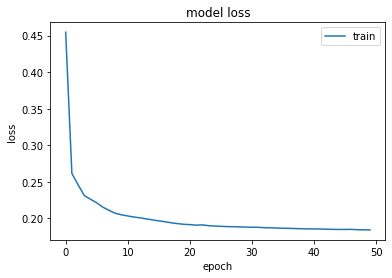

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
X_pred_d_3 = deep_autoencoder(X_train_3,X_test_3,50)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_d_3 = cal_mse(X_pred_d_3, X_test_3)

In [ ]:
thresh_3 = np.quantile(mse_d_3, 1/(1+contam))
idxs_3 = np.where(np.array(mse_d_3) >= thresh_3)[0]
print("[INFO] mse threshold: {}".format(thresh_3))
print("[INFO] {} outliers found".format(len(idxs_3)))

[INFO] mse threshold: 0.05299977443757511
[INFO] 50 outliers found


In [ ]:
# Predicted Y
Y_pred_3 = np.array([1]*len(Y_test_3))
Y_pred_3[idxs_3] = 7
Y_pred_3

array([1, 1, 1, ..., 7, 7, 7])

In [ ]:
print(confusion_matrix(Y_test_3, Y_pred_3))
print(classification_report(Y_test_3, Y_pred_3))

[[997   3]
 [  3  47]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1000
           7       0.94      0.94      0.94        50

    accuracy                           0.99      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.99      0.99      0.99      1050



###Variational autoencoder

In [ ]:
#We use the variational autoencoder that we built before
results_v_3 = vae_model.fit(X_train_3, X_train_3,
                        shuffle=True,
                        epochs=32,
                        batch_size=100)

Train on 6000 samples
Epoch 1/32
6000/6000 [==============================] - 1s 248us/sample - loss: 3510.1638
Epoch 2/32
6000/6000 [==============================] - 1s 240us/sample - loss: 1234.8481
Epoch 3/32
6000/6000 [==============================] - 1s 249us/sample - loss: 719.0267
Epoch 4/32
6000/6000 [==============================] - 1s 243us/sample - loss: 639.7662
Epoch 5/32
6000/6000 [==============================] - 1s 243us/sample - loss: 595.7783
Epoch 6/32
6000/6000 [==============================] - 1s 240us/sample - loss: 563.3362
Epoch 7/32
6000/6000 [==============================] - 1s 246us/sample - loss: 539.2737
Epoch 8/32
6000/6000 [==============================] - 1s 245us/sample - loss: 520.6773
Epoch 9/32
6000/6000 [==============================] - 1s 242us/sample - loss: 505.4305
Epoch 10/32
6000/6000 [==============================] - 1s 249us/sample - loss: 490.7772
Epoch 11/32
6000/6000 [==============================] - 2s 255us/sample - loss: 479.

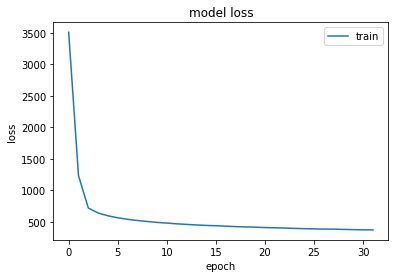

In [ ]:
#Plot the trend of loss
plt.plot(results_v_3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
#Use the model trained to do prediction in test set
X_pred_v_3 = vae_model.predict(X_test_3)

In [ ]:
# Measure the error between the reconstruction and the original image
mse_v_3 = cal_mse(X_pred_v_3, X_test_3) 

In [ ]:
thresh_v_3 = np.quantile(mse_v_3, 1/(1+contam))
idxs_v_3 = np.where(np.array(mse_v_3) >= thresh_v_3)[0]
print("[INFO] mse threshold: {}".format(thresh_v_3))
print("[INFO] {} outliers found".format(len(idxs_v_3)))

[INFO] mse threshold: 0.02453395165503024
[INFO] 50 outliers found


In [ ]:
# Predicted Y
Y_pred_v_3 = np.array([1]*len(Y_test_3))
Y_pred_v_3[idxs_v_3] = 7
Y_pred_v_3

array([1, 1, 1, ..., 7, 7, 7])

In [ ]:
print(confusion_matrix(Y_test_3_, Y_pred_v_3))
print(classification_report(Y_test_3_, Y_pred_v_3))

[[994   6]
 [  6  44]]
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      1000
           7       0.88      0.88      0.88        50

    accuracy                           0.99      1050
   macro avg       0.94      0.94      0.94      1050
weighted avg       0.99      0.99      0.99      1050

